In [1]:
import logging
import tensorflow as tf
from tensorflow import layers
#tf.logging.set_verbosity(tf.logging.ERROR)
from datetime import datetime
import os
import gym

import numpy as np

from replay_buffer import ReplayBuffer
from noise import AdaptiveParamNoiseSpec,NormalActionNoise,OrnsteinUhlenbeckActionNoise

In [2]:
class ActorNetwork(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.

    The output layer activation is a tanh to keep the action
    between -action_bound and action_bound
    """

    def __init__(self, name, sess, observation_space,  action_space,
                 learning_rate, tau, batch_size,
                 actor_model_save_path = 'results/models',
                 target_actor_model_save_path = 'results/models',
                 restore_model_flag=False,
                 restore_model_version = 0):
        """
        Parameters
        ----------
        name: str
            
        sess: tf.Session
            
        observation_space: gym.spaces.Box
            
        action_space: gym.spaces.Box
            
        learning_rate: float
            
        tau: float
            
        batch_size: int
            
        restore_model_flag: bool default=False
        
        actor_model_save_path_and_name: str default = 'results/models/actor_model.ckpt'
        
        target_actor_model_save_path_and_name: str default = 'results/models/target_actor_model.ckpt'
        """
        
        self.name = name
        self.sess = sess
        self.s_dim = observation_space.shape[0]
        self.a_dim = action_space.shape[0]
        self.action_bound_high = action_space.high
        self.action_bound_low = action_space.low
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size
        
        # Info for load pre-trained actor models
        self.actor_model_save_path = actor_model_save_path
        self.target_actor_model_save_path = target_actor_model_save_path
        
        self.restore_model_flag = restore_model_flag
        self.restore_model_version = self._find_the_most_recent_model_version() 
        if self.restore_model_flag and self.restore_model_version == -1:
            logging.error('You do not have pretrained models.\nPlease set "load_pretrained_agent_flag = False".')
        
        with tf.name_scope(self.name):
            
            with tf.variable_scope(self.name) as self.scope:
                # Create Actor Model
                self.inputs, self.out = self.create_actor_network()
                self.network_params = tf.trainable_variables(scope=self.name)
                self.actor_model_saver = tf.train.Saver(self.network_params) # Saver to save and restore model variables
                
                # Create Target Actor Model
                self.target_inputs, self.target_out = self.create_actor_network()
                self.target_network_params = tf.trainable_variables(scope=self.name)[len(self.network_params):]
                self.target_actor_model_saver = tf.train.Saver(self.target_network_params) # Saver to save and restore model variables
                
            # Op for periodically updating target network
            self.update_target_network_params = \
                [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                      tf.multiply(self.target_network_params[i], 1. - self.tau))
                    for i in range(len(self.target_network_params))]
                
            # This gradient will be provided by the critic network: d[Q(s,a)]/d[a]
            self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])
    
            # Combine the gradients here
            # The reason of negative self.action_gradient here is we want to do 
            # gradient ascent, and AdamOptimizer will do gradient descent when applying
            # a gradient.
            self.unnormalized_actor_gradients = tf.gradients(self.out, 
                                                             self.network_params, 
                                                             -self.action_gradient) 
            # Normalized actor gradient
            self.actor_gradients = list(map(lambda x: tf.divide(x, self.batch_size), self.unnormalized_actor_gradients))
    
            # Optimization Op
            self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(zip(self.actor_gradients, self.network_params))
            
            # Initialize variables in variable_scope: self.name
            # Note: make sure initialize variables **after** defining all variable
            self.sess.run(tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = self.name)))
            
            # Restor Actor and Target-Actor Models
            if self.restore_model_flag == True:
                actor_filepath = os.path.join(self.actor_model_save_path,
                                         self.name + '_' + str(self.restore_model_version)+'.ckpt')
                target_actor_filepath = os.path.join(self.actor_model_save_path,
                                         self.name + '_target_' + str(self.restore_model_version)+'.ckpt')
                self.restore_actor_and_target_actor_network(actor_filepath, 
                                                            target_actor_filepath)
                    
    def create_actor_network(self):
        """
        
        """
        inputs = tf.placeholder(tf.float32, shape=(None, self.s_dim), name = 'ActorInput')
        h1 = layers.Dense(units = 100, activation = tf.nn.relu, 
                          kernel_initializer = tf.initializers.truncated_normal)(inputs)
        h1 = layers.BatchNormalization()(h1)
        h1 = layers.Dropout(0.5)(h1)
        
        h2 = layers.Dense(units = 50, activation = tf.nn.relu, 
                          kernel_initializer = tf.initializers.truncated_normal)(h1)
        h2 = layers.BatchNormalization()(h2)
        h2 = layers.Dropout(0.5)(h2)
        
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        out = layers.Dense(units = self.a_dim, activation = tf.tanh, 
                           kernel_initializer=tf.initializers.random_uniform(minval = -0.003, maxval = 0.003), 
                           name = 'ActorOutput')(h2)
        return inputs, out
        
    def save_actor_network(self, version_number = 0):
        """save actor and target actor model"""
        actor_filepath = os.path.join(self.actor_model_save_path,
                                      self.name + '_' + str(version_number)+'.ckpt')
        target_actor_filepath = os.path.join(self.target_actor_model_save_path,
                                             self.name +'_target_' + str(version_number)+'.ckpt')
        
        self.actor_model_saver.save(self.sess, actor_filepath)
        self.target_actor_model_saver.save(self.sess, target_actor_filepath)
        
        logging.info('Actor model saved in path: {}.'.format(actor_filepath))
        logging.info('Target Actor model saved in path: {}.'.format(target_actor_filepath))

    def restore_actor_and_target_actor_network(self, actor_filepath, target_actor_filepath):
        """ 
        The following code is to inspect variables in a checkpoint:
            from tensorflow.python.tools import inspect_checkpoint as chkp
            chkp.print_tensors_in_checkpoint_file(file_path, tensor_name='', all_tensors=True, all_tensor_names=True)
        """
        # Initialize variables
        self.sess.run(tf.variables_initializer(self.network_params, name='init_network_params'))
        self.sess.run(tf.variables_initializer(self.target_network_params, name='init_target_network_params'))
        
        self.actor_model_saver.restore(self.sess, actor_filepath)
        self.target_actor_model_saver.restore(self.sess, target_actor_filepath)
        
        
        
        logging.info('Restored acotor: {}'.format(actor_filepath))
        logging.info('Restored target acotor: {}'.format(target_actor_filepath))

    def train(self, inputs, a_gradient):
        """Train actor"""
        self.sess.run(self.optimize, 
                      feed_dict={self.inputs: inputs,
                                 self.action_gradient: a_gradient})

    def predict(self, inputs):
        """
        Prediction of Actor Model.
        """
        return self.sess.run(self.out, 
                             feed_dict={self.inputs: inputs})

    def predict_target(self, inputs):
        """
        Prediction of Target Actor Model.
        """
        return self.sess.run(self.target_out, 
                             feed_dict={self.target_inputs: inputs})

    def update_target_network(self):
        """Update Target Actor Model"""
        self.sess.run(self.update_target_network_params)
    
    def _find_the_most_recent_model_version(self):
        """
        Returns
        -------
        the_most_recent_model_version: int
            the most recent model version. If no saved model, return -1.
        """
        # Find the most recent version
        model_version = []
        for file_name_temp in os.listdir(self.actor_model_save_path):
            if self.name+'_target_' in file_name_temp:
                _, version_temp = file_name_temp.split('.')[0].split(self.name+'_target_')
                model_version.append(version_temp)
        if len(model_version) != 0:
            the_most_recent_model_version = max([int(i) for i in model_version])
        else:
            the_most_recent_model_version = -1
        return the_most_recent_model_version

In [3]:
class CriticNetwork(object):
    """
    Input to the network is the state and action, output is Q(s,a).
    The action must be obtained from the output of the Actor network.

    """

    def __init__(self, name, sess, observation_space, action_space,
                 learning_rate, tau, gamma,
                 critic_model_save_path = 'results/models',
                 target_critic_model_save_path = 'results/models',
                 restore_model_flag=False,
                 restore_model_version = 0):
        """
        Parameters
        ----------
        name: str
            The name of this cirtic network. Giving a name to object of CriticNetwork
            is necessary to avoid messing up trainable variables together.
        sess: tf.Session
            tf.Session to run computational graph
        observation_space: gym.spaces.Box
            observation space of environment
        action_space: gym.spaces.Box
            action space of environment
        learning_rate: float
            learning rate to train CriticNetwork
        tau: float
            hyper-parameter weighting the update of target network
        gamma: float
            discount rate
        critic_model_save_path: str default = 'results/models'
            path of critic model we are going to save
        target_critic_model_save: str default = 'results/models/target_critic_model.ckpt'
            path of target critic model we are going to save
        restore_model_flag: bool default=False:
            indicator of whether to restore a pre-trained critic network
        restore_model_version: int default = 0
            if restore model, this parameter gives the number of specific version
            of models we are going to restore
        """
        # name is necessary, since we will reuse this graph multiple times.
        self.name = name
        self.sess = sess
        self.s_dim = observation_space.shape[0]
        self.a_dim = action_space.shape[0]
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma
        
        # Info for save and load pre-trained critic models
        self.critic_model_save_path = critic_model_save_path
        self.target_critic_model_save_path = target_critic_model_save_path
        
        self.restore_model_flag = restore_model_flag
        self.restore_model_version = self._find_the_most_recent_model_version()
        if self.restore_model_flag and self.restore_model_version == -1:
            raise Exception('You do not have pretrained models.\nPlease set "load_pretrained_agent_flag = False".')
        
        with tf.name_scope(self.name):
            
            with tf.variable_scope(self.name) as self.scope:
                # Create Critic Model
                self.inputs, self.action, self.out = self.create_critic_network()
                self.network_params = tf.trainable_variables(scope=self.name)
                self.critic_model_saver = tf.train.Saver(self.network_params) # Saver to save and restore model variables  
                
                # Create Target Critic Model
                self.target_inputs, self.target_action, self.target_out = self.create_critic_network()
                self.target_network_params = tf.trainable_variables(scope=self.name)[len(self.network_params):]
                self.target_critic_model_saver = tf.train.Saver(self.target_network_params)
            
            #Tracer()()
            # Op for periodically updating target network with online network
            # weights with regularization
            self.update_target_network_params = \
                [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
                                                      + tf.multiply(self.target_network_params[i], 1. - self.tau))
                    for i in range(len(self.target_network_params))]
    
            # Network target (y_i)
            self.target_q_value = tf.placeholder(tf.float32, [None, 1])
    
            # Define loss and optimization Op
            self.loss = tf.losses.mean_squared_error(labels = self.target_q_value,
                                                     predictions = self.out)
            self.optimize = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
    
            # Get the gradient of the net w.r.t. the action.
            # For each action in the minibatch (i.e., for each x in xs),
            # this will sum up the gradients of each critic output in the minibatch
            # w.r.t. that action. Each output is independent of all
            # actions except for one.
            self.action_grads = tf.gradients(self.out, self.action)
            
            # Initialize variables in variable_scope: self.name
            # Note: make sure initialize variables **after** defining all variable
            self.sess.run(tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = self.name)))
            
            # Restore Critic and Target Critic Models
            if self.restore_model_flag == True:
                critic_filepath = os.path.join(self.critic_model_save_path,
                                               self.name + '_' + str(self.restore_model_version)+'.ckpt')
                target_critic_filepath = os.path.join(self.critic_model_save_path,
                                                      self.name + '_target_' + str(self.restore_model_version)+'.ckpt')
                self.restore_critic_and_target_critic_network(critic_filepath, 
                                                              target_critic_filepath)

    def create_critic_network(self):
        """Create critic network"""
        obs = tf.placeholder(tf.float32, shape=(None, self.s_dim), name = 'CriticInputState')
        act = tf.placeholder(tf.float32, shape=(None, self.a_dim), name = 'CriticInputAction')
        
        h1_obs = layers.Dense(units = 400, activation = tf.nn.relu, 
                          kernel_initializer = tf.initializers.truncated_normal)(obs)
        h1_obs = layers.BatchNormalization()(h1_obs)
        h1_obs = layers.Dropout(0.5)(h1_obs)
        
        h1_act = layers.Dense(units = 400, activation = tf.nn.relu, 
                          kernel_initializer = tf.initializers.truncated_normal)(act)
        h1_act = layers.BatchNormalization()(h1_act)
        h1_act = layers.Dropout(0.5)(h1_act)
        
        merged = tf.concat([h1_obs, h1_act], axis=1)
        
        h2 = layers.Dense(units = 300, activation = tf.nn.relu, 
                          kernel_initializer = tf.initializers.truncated_normal)(merged)
        h2 = layers.BatchNormalization()(h2)
        h2 = layers.Dropout(0.5)(h2)
        
        # Linear layer connected to 1 output representing Q(s,a)
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        out = layers.Dense(units = 1,
                           kernel_initializer=tf.initializers.random_uniform(minval = -0.003, maxval = 0.003), 
                           name = 'CriticOutput')(h2)
        
        return obs, act, out

    def save_critic_network(self, version_number = 0):
        """
        Function used to save critic and target critic model
        Parameters
        ----------
        version_number: int default = 0
            the time when save this ciritic and its target critic models.
        """
        critic_filepath = os.path.join(self.critic_model_save_path,
                                      self.name + '_' + str(version_number)+'.ckpt')
        target_critic_filepath = os.path.join(self.target_critic_model_save_path,
                                             self.name +'_target_' + str(version_number)+'.ckpt')
        
        self.critic_model_saver.save(self.sess, critic_filepath)
        self.target_critic_model_saver.save(self.sess, target_critic_filepath)
        
        logging.info('Critic model saved in path: {}.'.format(critic_filepath))
        logging.info('Target Critic model saved in path: {}.'.format(target_critic_filepath))
        
    def restore_critic_and_target_critic_network(self, critic_filepath, target_critic_filepath):
        """ 
        The following code is to inspect variables in a checkpoint:
            from tensorflow.python.tools import inspect_checkpoint as chkp
            chkp.print_tensors_in_checkpoint_file(file_path, tensor_name='', all_tensors=True, all_tensor_names=True)
        """
        self.critic_model_saver.restore(self.sess, critic_filepath)
        self.target_critic_model_saver.restore(self.sess, target_critic_filepath)
        logging.info('Restored acotor: {}'.format(critic_filepath))
        logging.info('Restored target acotor: {}'.format(target_critic_filepath))

    def train(self, observation, action, target_q_value):
        """
        Returns
        -------
        loss: mean square error
            
        out: output of Critic_Network
            
        optimize: tf.operation
        """
        return self.sess.run([self.loss, self.out, self.optimize], 
                             feed_dict={self.inputs: observation,
                                        self.action: action,
                                        self.target_q_value: target_q_value})

    def predict(self, observation, action):
        return self.sess.run(self.out, 
                             feed_dict={self.inputs: observation,
                                        self.action: action})

    def predict_target(self, observation, action):
        """
        Prediction of Target-Critic Model
        """
        return self.sess.run(self.target_out, 
                             feed_dict={self.target_inputs: observation,
                                        self.target_action: action})

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, 
                             feed_dict={
                                     self.inputs: inputs,
                                     self.action: actions})

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)
    
    def _find_the_most_recent_model_version(self):
        """
        Returns
        -------
        the_most_recent_model_version: int
            the most recent model version
        """
        # Find the most recent version
        model_version = []
        for file_name_temp in os.listdir(self.critic_model_save_path):
            if self.name+'_target_' in file_name_temp:
                _, version_temp = file_name_temp.split('.')[0].split(self.name+'_target_')
                model_version.append(version_temp)
        if len(model_version) != 0:
            the_most_recent_model_version = max([int(i) for i in model_version])
        else:
            the_most_recent_model_version = -1
        return the_most_recent_model_version

In [4]:
class Agent_Actor_Critic():
    """
    LASAgent is the learning agent of Living Architecture System. Basically, it
    consists of three main components coding policies and value-functions:
        1. Extrinsically motivated actor-critic model
        2. Knowledge-based Intrinsically motivated actor-critic model
        3. Competence-based Intrinsically motivated actor-critic model
    And two main components producing intrinsic motivation
        1. Knowledge-based intrinsic motivation
        2. Competence-based intrinsic motivation
    """
    def __init__(self, sess, agent_name,
                 observation_space, action_space,
                 actor_lr = 0.0001, actor_tau = 0.001,
                 critic_lr = 0.0001, critic_tau = 0.001, gamma = 0.99,
                 minibatch_size = 64,
                 max_episodes = 50000, max_episode_len = 1000,
                 # Exploration Strategies
                 exploration_action_noise_type = 'ou_0.2',
                 exploration_epsilon_greedy_type = 'none',
                 # Save Summaries
                 save_dir = '',
                 experiment_runs = '',
                 # Save and Restore Actor-Critic Model
                 restore_actor_model_flag = False,
                 restore_critic_model_flag = False,
                 restore_env_model_flag = False,
                 restore_model_version = 0):
        """
        Intialize LASAgent.
        
        Parameters
        ----------
        actor_lr: float default = 0.0001
            actor model learning rate
        
        actor_tau: float default = 0.001
            target actor model updating weight
        
        critic_lr: float default = 0.0001
            critic model learning rate
        
        critic_tau: float default = 0.001
            target critic model updating weight
        
        gamma default:int = 0.99
            future reward discounting paramter
        
        minibatch_size:int default = 64
            size of minibabtch
        
        max_episodes:int default = 50000
            maximum number of episodes
        
        max_episode_len: int default = 1000
            maximum lenght of each episode
        
        exploration_action_noise_type: str default = 'ou_0.2',
            set up action noise. Options:
                1. 'none' (no action noise)
                2. 'adaptive-param_0.2'
                3. 'normal_0.2'
                4. 'ou_0.2' 
        
        exploration_epsilon_greedy_type: str default = 'none',
            set up epsilon-greedy.
            1. If exploration_epsilon_greedy_type == 'none', no epsilon-greedy.
            2. 'epsilon-greedy-max_1_min_0.05_decay_0.999'
        
        save_dir: string default='')
            directory to save tensorflow summaries and pre-trained models
        
        experiment_runs: str default = ''
            directory to save summaries of a specific run 
        
        restore_actor_model_flag: bool default = False
            indicate whether load pre-trained actor model
        
        restore_critic_model_flag: bool default = False
            indicate whetther load pre-trained critic model
        """
        # Init Environment Related Parameters
        self.sess = sess
        self.agent_name = agent_name
        self.action_space = action_space
        self.observation_space = observation_space
        
        self.save_dir = save_dir
        self.experiment_runs = experiment_runs
        # Temporary Memory
        self.first_experience = True
        self.observation_old = []
        self.action_old = []
        self.reward_new = []
        self.observation_new = []
        # =================================================================== #
        #                Initialize Global Hyper-parameters                   #
        # =================================================================== #        
        self.max_episodes = max_episodes
        self.max_episode_len = max_episode_len
        self.episode_counter = 1
        self.steps_counter = 1      # Steps elapsed in one episode
        self.total_step_counter = 1 # Steps elapsed in whole life
        self.render_env = False
        # =================================================================== #
        #                 Initialize Replay Buffers for                       #
        #         Extrinsic and Intrinsic Policy, and Environment Model        #
        # =================================================================== #         
        # ********************************************* #
        #         Replay Buffer for Extrinsic Policy    #
        # ********************************************* #
        self.buffer_size = 1000000
        self.random_seed = 1234
        self.replay_buffer = ReplayBuffer(self.buffer_size, self.random_seed)
        
        # =================================================================== #
        #      Initialize Parameters for Both Actor and Critic Model          #
        # =================================================================== #        
        self.minibatch_size = 64
        self.models_dir = os.path.join(self.save_dir,'models',self.experiment_runs)
        if not os.path.exists(self.models_dir):
            os.makedirs(self.models_dir)
        
        # =================================================================== #
        #       Initialize Extrinsically Motivated Actor-Critic Model         #
        # =================================================================== #
        # Extrinsically Motivated Actor
        self.extrinsically_motivated_actor_name = self.agent_name+'_extrinsically_motivated_actor_name'
        self.extrinsic_actor_lr = actor_lr
        self.extrinsic_actor_tau = actor_tau
        # Restore Pre-trained Actor Modles
        self.extrinsic_actor_model_save_path = self.models_dir
        self.target_extrinsic_actor_model_save_path = self.models_dir
        
        self.restore_extrinsic_actor_model_flag = restore_actor_model_flag
        self.restore_extrinsic_actor_model_version = restore_model_version
        
        self.extrinsic_actor_model = ActorNetwork(self.extrinsically_motivated_actor_name,
                                        self.sess, 
                                        self.observation_space, 
                                        self.action_space,
                                        self.extrinsic_actor_lr, 
                                        self.extrinsic_actor_tau,
                                        self.minibatch_size,
                                        self.extrinsic_actor_model_save_path,
                                        self.target_extrinsic_actor_model_save_path,
                                        self.restore_extrinsic_actor_model_flag,
                                        self.restore_extrinsic_actor_model_version)
        # Extrinsically Motivated Critic
        self.extrinsically_motivated_critic_name = self.agent_name+'_extrinsically_motivated_critic_name'
        self.extrinsic_critic_lr = critic_lr
        self.extrinsic_critic_tau = critic_tau
        self.extrinsic_gamma = gamma
        # Restore Pre-trained Critic Model
        self.extrinsic_critic_model_save_path = self.models_dir
        self.target_extrinsic_critic_model_save_path = self.models_dir
        
        self.restore_extrinsic_critic_model_flag = restore_critic_model_flag
        self.restore_extrinsic_critic_model_version = restore_model_version
        
        self.extrinsic_critic_model = CriticNetwork(self.extrinsically_motivated_critic_name,
                                          self.sess,
                                          self.observation_space,
                                          self.action_space,
                                          self.extrinsic_critic_lr,
                                          self.extrinsic_critic_tau,
                                          self.extrinsic_gamma,
                                          self.extrinsic_critic_model_save_path,
                                          self.target_extrinsic_critic_model_save_path,
                                          self.restore_extrinsic_critic_model_flag,
                                          self.restore_extrinsic_critic_model_version)
        
        # =================================================================== #
        #                  Initialize Exploration Strategies                  #
        # =================================================================== #        
        # 1. Action Noise to Maintain Exploration
        self.exploration_action_noise_type = exploration_action_noise_type
        self.actor_noise = self._init_action_noise(self.exploration_action_noise_type, self.action_space.shape[0])
        # 2. Epsilon-Greedy
        self.exploration_epsilon_greedy_type = exploration_epsilon_greedy_type # 'epsilon-greedy-max_1_min_0.05_decay_0.999'
        self.epsilon_max, self.epsilon_min, self.epsilon_decay = self._init_epsilon_greedy(self.exploration_epsilon_greedy_type)
        self.epsilon = self.epsilon_max     

# =================================================================== #
#                       Main Interaction Functions                    #
# =================================================================== #
    def perceive_and_act(self, observation, reward, done):
        """
        Perceive observation and reward, then return action based on current
        observation.
        
        Parameters
        ----------
        observation: np.shape(observation) = (obs_dim,)
            observation
        reward: float
            reward of previous action
        done: bool
            whether current simulation is done
            
        Returns
        -------
        action: np.shape(action) = (act_dim, )
            action generated by agent
        """
        self.observation_new = observation
        self.reward_new = reward
        self.done = done
        # *********************************** # 
        #            Produce Action           #
        # *********************************** #
        # If this is the first action, no complete experience to remember.
        if self.first_experience:
            action = self._act(self.observation_new)
            self.action_old = action
            self.observation_old = self.observation_new
            self.first_experience = False
            self.total_step_counter += 1
            return action
        # Action, added exploration noise
        action = self._act(self.observation_new)
        
        # *********************************** # 
        #        Remember Experiences         #
        # *********************************** #
        self.replay_buffer.add(self.observation_old, self.action_old, self.reward_new, self.done, self.observation_new)
        
        # *********************************** # 
        #             Train Models            #
        # *********************************** #
        self._train()
        
        # *********************************** # 
        #       Reset Temporary Variables     #
        # *********************************** #
        # Before return, set observation and action as old.
        self.observation_old = self.observation_new
        self.action_old = action
        self.total_step_counter += 1
        return action
    
    def _act(self, observation_new):
        """
        Produce action based on current observation.
        Parameters
        ----------
        observation_new: np.shape(observation) = (obs_dim,)
            
        Returns
        -------
        action: np.shape(action) = (act_dim, )
        """
        # Epsilon-Greedy
        if self.exploration_epsilon_greedy_type != 'none':
            if np.random.rand(1) <= self.epsilon:
                action = self.action_space.sample()
                if self.epsilon > self.epsilon_min:
                    self.epsilon *= self.epsilon_decay
                if self.total_step_counter % 2000 == 0:
                    print("epsilon:{}".format(self.epsilon))
                return action
        # Action Noise
        if self.exploration_action_noise_type != 'none':
            action = self.extrinsic_actor_model.predict(np.reshape(observation_new, [1, self.observation_space.shape[0]])) + self.actor_noise() #The noise is too huge.
        else:
            action = self.extrinsic_actor_model.predict(np.reshape(observation_new, [1, self.observation_space.shape[0]]))
        
        return action[0]
    
    def _train(self):
        """
        Train Actor-Critic Model
        """
        # Keep adding experience to the memory until
        # there are at least minibatch size samples
        # ************************************************** # 
        #  Train Extrinsically Motivated Actor-Critic Model  #
        # ************************************************** #
        if self.replay_buffer.size() > self.minibatch_size:
            # Random Samples
            s_batch, a_batch, r_batch, t_batch, s2_batch = \
                self.replay_buffer.sample_batch(int(self.minibatch_size))
            # Prioritized Samples
            
            # Calculate targets
            target_q = self.extrinsic_critic_model.predict_target(
                s2_batch, self.extrinsic_actor_model.predict_target(s2_batch))

            y_i = []
            for k in range(int(self.minibatch_size)):
                if t_batch[k]:
                    y_i.append(r_batch[k])
                else:
                    y_i.append(r_batch[k] + self.extrinsic_critic_model.gamma * target_q[k])

            # Update the critic given the targets
            critic_loss, predicted_q_value, _ = self.extrinsic_critic_model.train(\
                                                                                  s_batch,
                                                                                  a_batch,
                                                                                  np.reshape(y_i, (int(self.minibatch_size), 1)))
            
            # Update the actor policy using the sampled gradient
            a_outs = self.extrinsic_actor_model.predict(s_batch)
            grads = self.extrinsic_critic_model.action_gradients(s_batch, a_outs)
            self.extrinsic_actor_model.train(s_batch, grads[0])
            
            # Update target networks
            self.extrinsic_actor_model.update_target_network()
            self.extrinsic_critic_model.update_target_network()
        
    def _save_learned_model(self, version_number):
        # Save extrinsically motivated actor-critic model 
        self.extrinsic_actor_model.save_actor_network(version_number)
        self.extrinsic_critic_model.save_critic_network(version_number)
        logging.info('Save extrinsic_actor_model and extrinsic_critic_model: done.')
        
# =================================================================== #
#                    Initialization Helper Functions                  #
# =================================================================== # 
    def _init_epsilon_greedy(self, exploration_epsilon_greedy_type):
        """
        Initialize hyper-parameters for epsilon-greedy.
        Parameters
        ----------
        exploration_epsilon_greedy_type: str default = 'epsilon-greedy-max_1_min_0.05_decay_0.999'
            str for setting epsilon greedy. Please keep the format and just change float numbers.
            For default 'epsilon-greedy-max_1_min_0.05_decay_0.999', it means:
                maximum epsilon = 1
                minimum spsilom = 0.05
                epsilon decay = 0.999
            If exploration_epsilon_greedy_type == 'none', no epsilon-greedy.
        
        Returns
        -------
        epsilon_max: float
            maximum epsilon
        epsilon_min: float
            minimum spsilom
        epsilon_decay: float
            epsilon decay
        """
        if exploration_epsilon_greedy_type == 'none':
            epsilon_max=0
            epsilon_min=0
            epsilon_decay=0
        else:
            _, epsilon_max, _, epsilon_min, _, epsilon_decay = exploration_epsilon_greedy_type.split('_')
        
        return float(epsilon_max), float(epsilon_min), float(epsilon_decay)
    
    def _init_action_noise(self, action_noise_type='ou_0.2', nb_actions=1):
        """
        Initialize action noise object.
        
        Parameters
        ----------
        action_noise_type: str default = 'ou_0.2'
            type of action noise:
                1. 'none' (no action noise)
                2. 'adaptive-param_0.2'
                3. 'normal_0.2'
                4. 'ou_0.2'
        nb_actions: int default = 1
            dimension of action space
        
        Returns
        -------
            action_noise: object of ActionNoise class.
        """
        if action_noise_type == 'none':
            pass
        elif 'adaptive-param' in action_noise_type:
            _, stddev = action_noise_type.split('_')
            param_noise = AdaptiveParamNoiseSpec(initial_stddev=float(stddev), desired_action_stddev=float(stddev))
            return param_noise
        elif 'normal' in action_noise_type:
            _, stddev = action_noise_type.split('_')
            action_noise = NormalActionNoise(mu=np.zeros(nb_actions), sigma=float(stddev) * np.ones(nb_actions))
            return action_noise
        elif 'ou' in action_noise_type:
            _, stddev = action_noise_type.split('_')
            action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(nb_actions), sigma=float(stddev) * np.ones(nb_actions))
            return action_noise
        else:
            raise RuntimeError('unknown noise type "{}"'.format(action_noise_type))


In [5]:
env = gym.make('Pendulum-v0')
observation = env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
agent_name = 'CartPole_v0'
observation_space = env.observation_space
action_space = env.action_space
observation_space_name = [], 
action_space_name = []
x_order_MDP = 1
x_order_MDP_observation_type = 'concatenate_observation'
occupancy_reward_type = 'IR_distance'
interaction_mode = 'virtual_interaction'
load_pretrained_agent_flag = False


# Model saving directory
model_version_number = 0
agent_model_save_dir = os.path.join(os.path.abspath('..'),'Experiment_results',agent_name)
tf_session = tf.Session()
agent = Agent_Actor_Critic(tf_session,
                                agent_name,
                                observation_space,
                                action_space,
                                actor_lr = 0.0001, actor_tau = 0.001,
                                critic_lr = 0.0001, critic_tau = 0.001, gamma = 0.99,
                                minibatch_size = 64,
                                max_episodes = 5000, max_episode_len = 1000,
                                # Exploration Strategies
                                exploration_action_noise_type = 'none', #'ou_0.2',
                                exploration_epsilon_greedy_type = 'epsilon-greedy-max_1_min_0.05_decay_0.9',#'none',#
                                # Save Summaries
                                save_dir = agent_model_save_dir,
                                experiment_runs = datetime.now().strftime("%Y%m%d-%H%M%S"),
                                # Save and Restore Actor-Critic Model
                                restore_actor_model_flag = False,
                                restore_critic_model_flag = False)

In [7]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt

max_episode_num = 1000
cumulative_reward_history = []
episodes = []
for episode in range(max_episode_num):
    observation = env.reset()
    done = False
    reward = 0
    i = 1
    cumulative_reward = 0
    while not done:
        env.render()
        action = agent.perceive_and_act(observation, reward, done)

        observation, reward, done, info = env.step(action)
        cumulative_reward += reward
        #print('Episode: {}, Step: {}, Reward: {}'.format(episode, i, reward))
        i += 1
    print('Episode: {}, Cumulative Reward: {}'.format(episode,cumulative_reward))
    cumulative_reward_history.append(cumulative_reward)
    episodes.append(episode)
    

Episode: 0, Cumulative Reward: -1042.8403127037682
Episode: 1, Cumulative Reward: -1277.8464286522083
Episode: 2, Cumulative Reward: -1367.0324864114855
Episode: 3, Cumulative Reward: -1868.760567071227
Episode: 4, Cumulative Reward: -1902.745356392851
Episode: 5, Cumulative Reward: -1254.8984344352957
Episode: 6, Cumulative Reward: -1390.9585549349958
Episode: 7, Cumulative Reward: -1196.269055041974
Episode: 8, Cumulative Reward: -1326.800975617984
Episode: 9, Cumulative Reward: -1360.4845283948587
Episode: 10, Cumulative Reward: -1320.715030337274
Episode: 11, Cumulative Reward: -1171.0709221235138
Episode: 12, Cumulative Reward: -1315.4513261861832
Episode: 13, Cumulative Reward: -1335.1522629062752
Episode: 14, Cumulative Reward: -1294.9235279090726
Episode: 15, Cumulative Reward: -1222.2351275454396
Episode: 16, Cumulative Reward: -1242.1677952277225
Episode: 17, Cumulative Reward: -1187.7195944721827
Episode: 18, Cumulative Reward: -1240.2543798217432
Episode: 19, Cumulative Rew

Episode: 159, Cumulative Reward: -378.45155386000283
Episode: 160, Cumulative Reward: -1002.5307696436313
Episode: 161, Cumulative Reward: -628.8096606412342
Episode: 162, Cumulative Reward: -759.2099014865919
Episode: 163, Cumulative Reward: -882.3612787591578
Episode: 164, Cumulative Reward: -1022.8283341712487
Episode: 165, Cumulative Reward: -507.32480329148194
Episode: 166, Cumulative Reward: -783.1620164197386
Episode: 167, Cumulative Reward: -621.3016322725445
Episode: 168, Cumulative Reward: -698.8533560182775
Episode: 169, Cumulative Reward: -861.2189177773024
Episode: 170, Cumulative Reward: -769.0064858962597
Episode: 171, Cumulative Reward: -770.6520268963274
Episode: 172, Cumulative Reward: -732.8582895950838
Episode: 173, Cumulative Reward: -267.34115632057296
Episode: 174, Cumulative Reward: -743.4238034682569
Episode: 175, Cumulative Reward: -505.0848276820102
Episode: 176, Cumulative Reward: -831.0266690431075
Episode: 177, Cumulative Reward: -233.65713615920137
Episod

Episode: 316, Cumulative Reward: -120.8905131682626
Episode: 317, Cumulative Reward: -241.65193288607398
Episode: 318, Cumulative Reward: -358.29725412132063
Episode: 319, Cumulative Reward: -122.73069321248693
Episode: 320, Cumulative Reward: -484.3754658647334
Episode: 321, Cumulative Reward: -241.87669493187374
Episode: 322, Cumulative Reward: -125.43101694281246
Episode: 323, Cumulative Reward: -0.9253132700298894
Episode: 324, Cumulative Reward: -124.84199799063038
Episode: 325, Cumulative Reward: -232.1816011193139
Episode: 326, Cumulative Reward: -122.63726123482013
Episode: 327, Cumulative Reward: -123.54839555794976
Episode: 328, Cumulative Reward: -122.98443074078382
Episode: 329, Cumulative Reward: -120.5967404703593
Episode: 330, Cumulative Reward: -122.6878092164808
Episode: 331, Cumulative Reward: -601.674648396079
Episode: 332, Cumulative Reward: -123.92160397937346
Episode: 333, Cumulative Reward: -595.8196791189757
Episode: 334, Cumulative Reward: -0.24709486777092657


Episode: 471, Cumulative Reward: -120.63901926755362
Episode: 472, Cumulative Reward: -242.1816269330705
Episode: 473, Cumulative Reward: -478.7856290913613
Episode: 474, Cumulative Reward: -243.151512233741
Episode: 475, Cumulative Reward: -592.4110505227856
Episode: 476, Cumulative Reward: -363.7354833712076
Episode: 477, Cumulative Reward: -588.0250893383599
Episode: 478, Cumulative Reward: -120.73245531335121
Episode: 479, Cumulative Reward: -124.17520177203627
Episode: 480, Cumulative Reward: -1.6212301209653057
Episode: 481, Cumulative Reward: -232.7544320525982
Episode: 482, Cumulative Reward: -122.93534192450639
Episode: 483, Cumulative Reward: -241.8320039671489
Episode: 484, Cumulative Reward: -243.57384242637104
Episode: 485, Cumulative Reward: -241.7445925967384
Episode: 486, Cumulative Reward: -126.37430898974412
Episode: 487, Cumulative Reward: -373.3146344454824
Episode: 488, Cumulative Reward: -121.36586732931195
Episode: 489, Cumulative Reward: -122.64977010990317
Epis

Episode: 627, Cumulative Reward: -123.48889296467141
Episode: 628, Cumulative Reward: -124.62910336949875
Episode: 629, Cumulative Reward: -476.1177881087296
Episode: 630, Cumulative Reward: -123.0327284812863
Episode: 631, Cumulative Reward: -123.12299463413905
Episode: 632, Cumulative Reward: -122.12622463514543
Episode: 633, Cumulative Reward: -239.3382029664931
Episode: 634, Cumulative Reward: -240.1497485582993
Episode: 635, Cumulative Reward: -0.7334808782809177
Episode: 636, Cumulative Reward: -580.3128872484713
Episode: 637, Cumulative Reward: -123.93235461824462
Episode: 638, Cumulative Reward: -124.36746738829554
Episode: 639, Cumulative Reward: -1.8631312235098547
Episode: 640, Cumulative Reward: -476.5568565884675
Episode: 641, Cumulative Reward: -486.6095319485106
Episode: 642, Cumulative Reward: -354.1390358573103
Episode: 643, Cumulative Reward: -242.91679081123405
Episode: 644, Cumulative Reward: -123.61517653899769
Episode: 645, Cumulative Reward: -365.6247273914781
Ep

Episode: 782, Cumulative Reward: -122.36761244827443
Episode: 783, Cumulative Reward: -351.2427218561528
Episode: 784, Cumulative Reward: -689.3442418525037
Episode: 785, Cumulative Reward: -120.74870950729698
Episode: 786, Cumulative Reward: -609.0666873074234
Episode: 787, Cumulative Reward: -125.03299816471149
Episode: 788, Cumulative Reward: -126.31255647708836
Episode: 789, Cumulative Reward: -627.7268515382053
Episode: 790, Cumulative Reward: -120.74741141647601
Episode: 791, Cumulative Reward: -122.88472912094005
Episode: 792, Cumulative Reward: -242.78637066590395
Episode: 793, Cumulative Reward: -361.2655839116635
Episode: 794, Cumulative Reward: -481.32813532435495
Episode: 795, Cumulative Reward: -126.44919149680298
Episode: 796, Cumulative Reward: -242.6345596073584
Episode: 797, Cumulative Reward: -485.3457997360751
Episode: 798, Cumulative Reward: -239.95320540952582
Episode: 799, Cumulative Reward: -243.48712871465602
Episode: 800, Cumulative Reward: -229.20625617968125


Episode: 938, Cumulative Reward: -124.90909287617666
Episode: 939, Cumulative Reward: -120.91773324791106
Episode: 940, Cumulative Reward: -363.0066902538082
Episode: 941, Cumulative Reward: -123.38900146861663
Episode: 942, Cumulative Reward: -123.95050050916296
Episode: 943, Cumulative Reward: -126.77214823595709
Episode: 944, Cumulative Reward: -365.12314488219016
Episode: 945, Cumulative Reward: -360.8558858777742
Episode: 946, Cumulative Reward: -348.85753466979065
Episode: 947, Cumulative Reward: -358.1721174321567
Episode: 948, Cumulative Reward: -474.9755321490512
epsilon:0.04710128697246249
Episode: 949, Cumulative Reward: -124.95963119040705
Episode: 950, Cumulative Reward: -123.3499961644961
Episode: 951, Cumulative Reward: -600.2830493027876
Episode: 952, Cumulative Reward: -124.1761738378542
Episode: 953, Cumulative Reward: -123.88086332239024
Episode: 954, Cumulative Reward: -360.5038477533114
Episode: 955, Cumulative Reward: -489.410710311959
Episode: 956, Cumulative Rew

In [9]:
agent._save_learned_model(version_number=1)
tf_session.close()

<IPython.core.display.Javascript object>


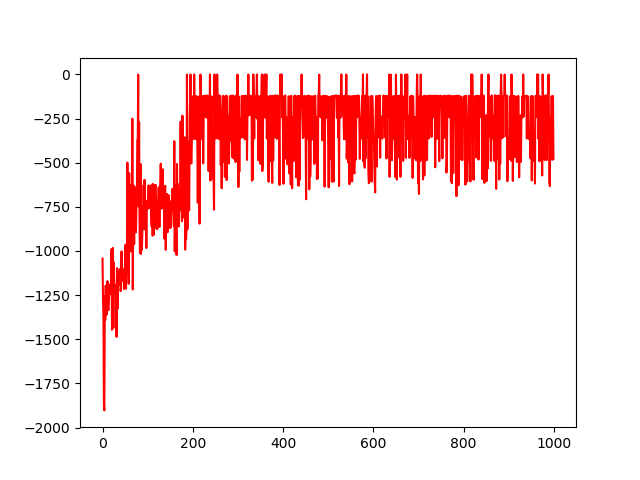

In [10]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(episodes,cumulative_reward_history, c="r")